<a href="https://colab.research.google.com/github/manmeet3/Deep_Learning2/blob/master/Asg2/B_tf-gradient-tape-linear-clfs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

B. Low level tensorflow code - Use gradient tape and low level tensorflow code (do not use keras) to build a linear classifier, svm classifier (hint: adding margin to the of linear  loss) and deep neural network classifier. Provide the necessary metrics for performance of classifier as well as visualizations. Also build a deep neural network by subclassing the keras layer class (see slides - not functional api  and not using denselayer class - you need to define your own MyDenseLayer using subclassing    ) and demonstrate the performance of it.   - check code and links in slides for hints

In [ ]:
#https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-3/v-3/1

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

tf.variable is the class meant to manage modifiable state in tensorflow

## Creating tf variables

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-0.31270367],
       [ 1.0300264 ],
       [ 0.20949052]], dtype=float32)>


In [ ]:
v.assign(tf.ones((3,1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>


In [ ]:
v[0, 0].assign(3.)
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>


In [ ]:
v.assign_add(tf.ones((3,1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

In [ ]:
a = tf.ones((2,2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a,b)
e *= d

In [ ]:
a

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [ ]:
b

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1., 1.])>

## Using GradientTape on simple probs

In [2]:
# A tf variable maintains shared, persistent state manipulated by a program.
input_var = tf.Variable(initial_value=3.)

with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)

# https://www.tensorflow.org/api_docs/python/tf/print -- addtl formats and
# piping to stderr
tf.print(input_var)
tf.print(result)
tf.print(gradient)

3
9
6


In [ ]:
input_const = tf.constant(3.)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)

tf.print(input_const)
tf.print(result)
tf.print(gradient)

3
9
6


In [ ]:
# compute second-order gradients
time = tf.Variable(1.)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)

tf.print(position)
tf.print(speed)
tf.print(acceleration)


4.9
9.8
9.8


## Linear Classifier with GradientTape

In [3]:
# key in this problem is understanding how to generate these samples, visualizing them, and writing a linear clf
num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)
positive_samples = np.random.multivariate_normal(mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class)

In [5]:
print(negative_samples.shape)
print(positive_samples.shape)

(1000, 2)
(1000, 2)


In [7]:
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [8]:
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype='float32'), np.ones((num_samples_per_class, 1), dtype='float32')))

In [12]:
inputs.shape

(2000, 2)

In [13]:
targets.shape

(2000, 1)

In [19]:
targets[1000] # 1k list of 0s followd by 1k list of 1s

array([1.], dtype=float32)

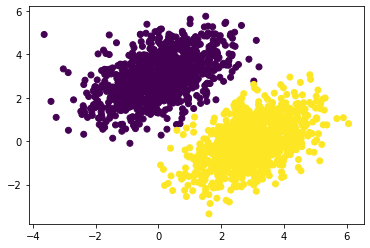

In [20]:
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0]) # positive samples and negative samples
plt.show()

In [27]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [28]:
tf.print(W)
tf.print(b)

[[0.482011795]
 [0.55212009]]
[0]


In [ ]:
def model(inputs):
  return tf.matmul(inputs, W) + b

In [ ]:
def square_loss(targets, predictions):
  per_sample_losses = tf.square(targets - predictions)
  return tf.reduce_mean(per_sample_losses)

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
  with tf.GradientTape() as tape:
    predictions = model(inputs)
    loss = square_loss(predictions, targets)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)
  return loss

In [ ]:
for step in range(20):
  loss = training_step(inputs, targets)
  print('Loss at step %d: %.4f' % (step, loss))

Loss at step 0: 5.1711
Loss at step 1: 0.6023
Loss at step 2: 0.2028
Loss at step 3: 0.1328
Loss at step 4: 0.1149
Loss at step 5: 0.1057
Loss at step 6: 0.0984
Loss at step 7: 0.0919
Loss at step 8: 0.0860
Loss at step 9: 0.0806
Loss at step 10: 0.0757
Loss at step 11: 0.0712
Loss at step 12: 0.0670
Loss at step 13: 0.0633
Loss at step 14: 0.0598
Loss at step 15: 0.0567
Loss at step 16: 0.0538
Loss at step 17: 0.0512
Loss at step 18: 0.0488
Loss at step 19: 0.0466


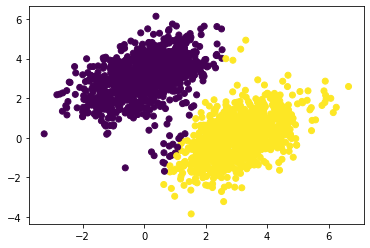

In [ ]:
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

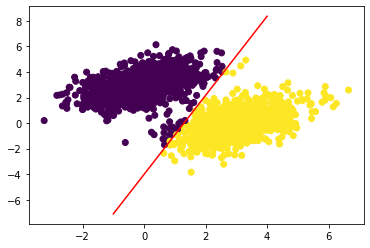

In [ ]:
x = np.linspace(-1, 4, 100)
y = -W[0]/W[1] * x + (0.5 -b) / W[1]
plt.plot(x, y, '-r')
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)

## DNN by subclassing keras layer class

Just like LEGO bricks, you can only "clip" together layers that are compatible in terms of input and output

In [29]:
from tensorflow import keras

In [ ]:
class SimpleDense(keras.layers.Layer):

  def __init__(self, units, activation=None):
    super(SimpleDense, self).__init__()
    self.units = units
    self.activation = activation

  def build(self, input_shape):
    input_dim = input_shape[-1]
    self.W = self.add_weight(shape=(input_dim, self.units),
                             initializer='random_normal')
    self.b = self.add_weight(shape=(self.units,), 
                             initializer='zeros')
    
  def call(self, inputs):
    y = tf.matmul(inputs, self.W) + self.b
    if self.activation is not None:
      y = self.activation(y)
    return y